In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn

In [251]:
df_train = pd.read_csv("data/DA_titanic_train.csv")
df_test = pd.read_csv("data/DA_titanic_test.csv")

In [252]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    object 
 5   Age          494 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     623 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 58.6+ KB


In [253]:
df_train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000
mean,459.128205,0.383013,2.328526,29.658745,0.519231,0.354167,30.523470
std,257.314092,0.486511,0.822684,14.770773,1.071871,0.775559,48.186064
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,241.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,460.500000,0.000000,3.000000,28.000000,0.000000,0.000000,13.931250
75%,683.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [254]:
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
5,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
6,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
7,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
8,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
9,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S


A train adatokat első körben megvizsgálva látható, hogy 3 oszlop tartalmaz hiányos adatokat: az összesen 624 utas közül csak 494-nek ismerük a korát, 128-nak a cabin számát és 623-nak a felszállás helyét.

A PassengerId az utas egyedi azonosítója, egy integer. Mivel ez az adatbázisban elfoglalt helyét mutatja csak meg az utasnak, ezért várhatóan ezt nem fogom felhasználni.

A Survived alapján osztályozzuk az utasokat, értéke 0, amennyiben áldozat, 1 amennyiben túlélő. Összesen az utasok 38.3%-a élte túl a balesetet, tehát ez egy kiegyensúlyozatlan adathalmaz.

A Pclass fejezi ki, milyen osztályra szólt a jegye. Értéke 1,2,3 számok közül kerül ki, amely kifejezi, hogy melyik osztályon utazott.

A Name az utas neve. Elsőként a vezetéknév, vagy vezetéknevek szerepelnek, majd vessző után az utas titulusa, majd a keresztnevek, leánykori nevek, becenevek szerepelnek. A titulus információként szolgálhat az utas családi állapotáról, nemesi rangjáról, amely befolyásolhatta a túlélési esélyeit.

A Sex az utas neme, male abban az esetben ha férfi, female abban az esetben ha nő.

Az Age az utas kora években mérve, értéke 0.67 (8 hónap) és 80 között van.

A SibSp az utas fedélzeten lévő testvéreinek és házastársainak a száma.

A Parch az utas fedélzeten lévő szüleinek és gyerekeinek a száma.

A Ticket az utas jegyének a számát jelenti. Nem találtam egységes szabályt a jelentésére, a szám valószínűleg egy azonosító, az előtte lévő karakterek pedig amennyiben vannak, a jegy vételét azonosíthatják, néhány esetben város névvel. Több utasnak is lehet ugyanaz a jegye, amely szintén az utasok közötti kapcsolatnak egy jele, amely befolyásolhatja a túlélési esélyüket. Ez azonban egy olyan tulajdonság, amely hiányos adatok esetén hamis adatokat eredményez, így használhatósága kérdéses.

A Fare a jegyért fizetett összeg, lebegőpontos szám. Egy jegy több személyre is szólhat, ezért a személyenkénti árat megkaphatjuk, ha elosztjuk az árat azzal hány emberre szól a jegy. Mivel ez utóbbi információ függ attól, hogy az adatbázis mennyire teljes, a használhatósága ennek a számnak kérdéses.

A Cabin az utas kabinjának a száma. Az első karakter a fedélzetet, az utána következő szám pedig a kabin szinten belüli elhelyezkedését jelenti. Az utas kabinjának elhelyezkedése befolyásolatta a túlélés esélyét, azonban ez egy nagyon hiányos információ, így kétséges hogy mennyire lehet felhasználni. Néhány utas esetén több kabin is meg van adva, ezek egymáshoz közel helyezkednek, így ez esetben az első megadott kabint fogom választani. Több utas is lehet ugyanabban a kabinban, ami szintén befolyásolhatta a túlélési esélyeiket, azonban itt még inkább hiányosak az adatok, így ennek a használhatósága is kérdéses.

Az Embarked a hajóra felszállás helyét jelöli, C karakter Cherbourg, Q karakter Queenstown, S karakter Southampton




In [255]:
df_train["Sex"] = (df_train["Sex"] == "female") * 1

In [256]:
from collections import Counter

cabin_elements = Counter(df_train["Cabin"])
cabin_elements.pop(np.nan)
ticket_elements = Counter(df_train["Ticket"])

df_train["NoCabin"] = df_train["Cabin"]
df_train["NoTicket"] = df_train["Ticket"]
df_train = df_train.replace({"NoCabin": cabin_elements, "NoTicket": ticket_elements})
df_train["Relatives"] = df_train["SibSp"] + df_train["Parch"]
df_train["Deck"] = df_train["Cabin"].str.slice(0,1)
df_train["Room"] = df_train["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
df_train["Title"] = df_train["Name"].str.split(",").str[1].str.split(".").str[0]
df_train["UnitFare"] = df_train["Fare"]/df_train["NoTicket"]



df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NoCabin,NoTicket,Relatives,Deck,Room,Title,UnitFare
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,1,1,NaN,NaN,Mr,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,1,C,85.0,Mrs,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,1,0,NaN,NaN,Miss,7.9250
3,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,NaN,1,0,NaN,NaN,Mr,8.0500
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,NaN,1,1,NaN,NaN,Mrs,30.0708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,884,0,2,"Banfield, Mr. Frederick James",0,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S,NaN,1,0,NaN,NaN,Mr,10.5000
620,885,0,3,"Sutehall, Mr. Henry Jr",0,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,NaN,1,0,NaN,NaN,Mr,7.0500
621,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S,1.0,1,0,B,42.0,Miss,30.0000
622,889,0,3,"Johnston, Miss. Catherine Helen \Carrie\""""",1,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,2,3,NaN,NaN,Miss,11.7250


In [257]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  624 non-null    int64  
 1   Survived     624 non-null    int64  
 2   Pclass       624 non-null    int64  
 3   Name         624 non-null    object 
 4   Sex          624 non-null    int32  
 5   Age          494 non-null    float64
 6   SibSp        624 non-null    int64  
 7   Parch        624 non-null    int64  
 8   Ticket       624 non-null    object 
 9   Fare         624 non-null    float64
 10  Cabin        128 non-null    object 
 11  Embarked     623 non-null    object 
 12  NoCabin      128 non-null    float64
 13  NoTicket     624 non-null    int64  
 14  Relatives    624 non-null    int64  
 15  Deck         128 non-null    object 
 16  Room         125 non-null    float64
 17  Title        624 non-null    object 
 18  UnitFare     624 non-null    float64
dtypes: float

In [258]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,NoCabin,NoTicket,Relatives,Room,UnitFare
count,624.000000,624.000000,624.000000,624.000000,494.000000,624.000000,624.000000,624.000000,128.000000,624.000000,624.000000,125.000000,624.000000
mean,459.128205,0.383013,2.328526,0.365385,29.658745,0.519231,0.354167,30.523470,1.500000,1.500000,0.873397,46.384000,20.320522
std,257.314092,0.486511,0.822684,0.481924,14.770773,1.071871,0.775559,48.186064,0.851122,0.941294,1.572740,33.383593,26.871582
min,1.000000,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000
25%,241.750000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,7.895800,1.000000,1.000000,0.000000,22.000000,7.775000
50%,460.500000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,13.931250,1.000000,1.000000,0.000000,36.000000,10.500000
75%,683.250000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,30.000000,2.000000,2.000000,1.000000,68.000000,23.287500
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,4.000000,5.000000,10.000000,128.000000,256.164600


Az új, származtatott tulajdonságok a következőek:

NoCabin,  hány emberrel utazott egy kabinban,

NoTicket, hány emberrel osztozott a jegyén,

Relatives, összesen hány rokona (gyerek, szülő, házastárs, testvér) utazott a hajón,

Deck, melyik szinten helyezkedett el a kabinja,

Room, a szinten belül melyik szobában helyezkedett el a kabinja,

Title, a titulusa,

UnitFare a jegye egységára.


Text(0, 0.5, 'Utasok száma')

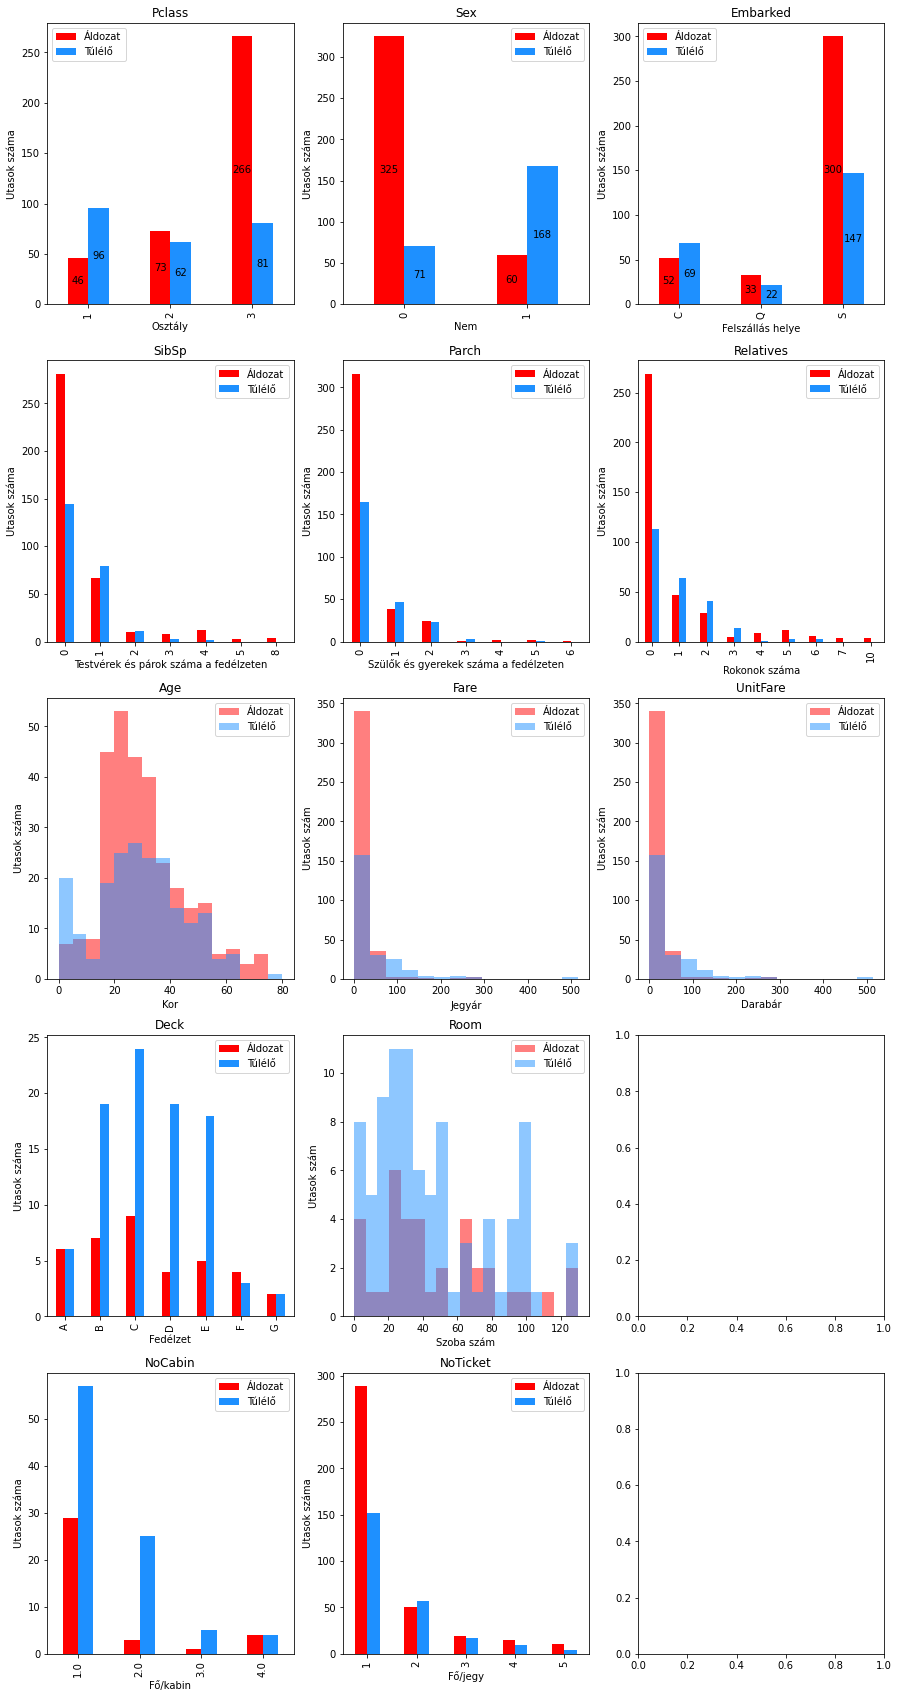

In [259]:
df_train_dead = df_train[df_train["Survived"] == 0]
df_train_survived = df_train[df_train["Survived"] == 1]


fig, axes = plt.subplots(nrows=5, ncols=3)
# fig.tight_layout(pad=1)
fig.set_size_inches(15,30)
df_pclass = pd.DataFrame({"Áldozat": df_train_dead.groupby("Pclass").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Pclass").count()["PassengerId"]})
ax = df_pclass.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,0])
ax.set_title("Pclass")
ax.set_xlabel("Osztály")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_sex = pd.DataFrame({"Áldozat": df_train_dead.groupby("Sex").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Sex").count()["PassengerId"]})
ax = df_sex.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,1])
ax.set_title("Sex")
ax.set_xlabel("Nem")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_sibsp = pd.DataFrame({"Áldozat": df_train_dead.groupby("SibSp").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("SibSp").count()["PassengerId"]})
ax = df_sibsp.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[1,0])
ax.set_title("SibSp")
ax.set_xlabel("Testvérek és párok száma a fedélzeten")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_parch = pd.DataFrame({"Áldozat": df_train_dead.groupby("Parch").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Parch").count()["PassengerId"]})
ax = df_parch.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[1,1])
ax.set_title("Parch")
ax.set_xlabel("Szülők és gyerekek száma a fedélzeten")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')
  
df_embarked = pd.DataFrame({"Áldozat": df_train_dead.groupby("Embarked").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Embarked").count()["PassengerId"]})
ax = df_embarked.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[0,2])
ax.set_title("Embarked")
ax.set_xlabel("Felszállás helye")
ax.set_ylabel("Utasok száma")
for i in ax.patches:
    ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')

df_age = pd.DataFrame({"Áldozat": df_train_dead["Age"],
                          "Túlélő": df_train_survived["Age"]})
ax = df_age.plot.hist(bins=np.arange(0,81,5), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[2,0])
ax.set_title("Age")
ax.set_ylabel("Utasok száma")
ax.set_xlabel("Kor")

df_relatives = pd.DataFrame({"Áldozat": df_train_dead.groupby("Relatives").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Relatives").count()["PassengerId"]})
ax = df_relatives.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[1,2])
ax.set_title("Relatives")
ax.set_xlabel("Rokonok száma")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')
    
df_fare = pd.DataFrame({"Áldozat": df_train_dead["Fare"],
                          "Túlélő": df_train_survived["Fare"]})
ax = df_fare.plot.hist(bins=np.linspace(0,515,15), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[2,1])
ax.set_title("Fare")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Jegyár")

df_unitfare = pd.DataFrame({"Áldozat": df_train_dead["UnitFare"],
                          "Túlélő": df_train_survived["UnitFare"]})
ax = df_fare.plot.hist(bins=np.linspace(0,515,15), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[2,2])
ax.set_title("UnitFare")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Darabár")

df_relatives = pd.DataFrame({"Áldozat": df_train_dead.groupby("Deck").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("Deck").count()["PassengerId"]})
ax = df_relatives.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[3,0])
ax.set_title("Deck")
ax.set_xlabel("Fedélzet")
ax.set_ylabel("Utasok száma")
# for i in ax.patches:
#     ax.annotate(str(int(i.get_height())), xy=(i.get_x()+i.get_width()/2, i.get_height()/2), ha='center', va='center')
    
df_unitfare = pd.DataFrame({"Áldozat": df_train_dead["Room"],
                          "Túlélő": df_train_survived["Room"]})
ax = df_unitfare.plot.hist(bins=np.linspace(0,130,20), alpha=0.5, color=['red', 'dodgerblue'], ax=axes[3,1])
ax.set_title("Room")
ax.set_ylabel("Utasok szám")
ax.set_xlabel("Szoba szám")

df_nocabin = pd.DataFrame({"Áldozat": df_train_dead.groupby("NoCabin").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("NoCabin").count()["PassengerId"]})
ax = df_nocabin.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[4,0])
ax.set_title("NoCabin")
ax.set_xlabel("Fő/kabin")
ax.set_ylabel("Utasok száma")

df_noticket = pd.DataFrame({"Áldozat": df_train_dead.groupby("NoTicket").count()["PassengerId"],
                          "Túlélő": df_train_survived.groupby("NoTicket").count()["PassengerId"]})
ax = df_noticket.plot(kind='bar', color=['red', 'dodgerblue'], ax=axes[4,1])
ax.set_title("NoTicket")
ax.set_xlabel("Fő/jegy")
ax.set_ylabel("Utasok száma")

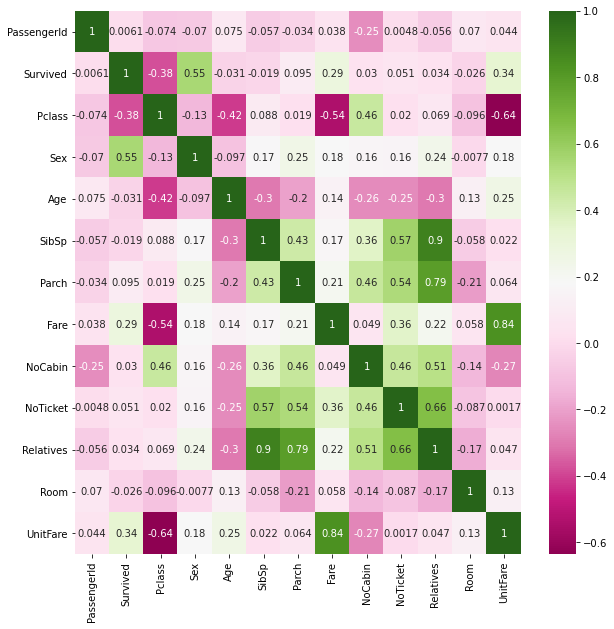

In [260]:
corrMatrix = df_train.corr()
plt.figure(figsize=(10,10))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

In [261]:
df_train["Deck"]= df_train["Deck"].fillna("N")
df_train["Room"] = df_train["Room"].fillna(df_train["Room"].mean())

one_hot = pd.get_dummies(df_train["Deck"], prefix="Deck")
df_train = df_train.join(one_hot)
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,UnitFare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,Mr,7.2500,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,Mrs,71.2833,0,0,1,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,7.9250,0,0,0,0,0,0,0,1
3,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,Mr,8.0500,0,0,0,0,0,0,0,1
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,...,Mrs,30.0708,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,884,0,2,"Banfield, Mr. Frederick James",0,28.0,0,0,C.A./SOTON 34068,10.5000,...,Mr,10.5000,0,0,0,0,0,0,0,1
620,885,0,3,"Sutehall, Mr. Henry Jr",0,25.0,0,0,SOTON/OQ 392076,7.0500,...,Mr,7.0500,0,0,0,0,0,0,0,1
621,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,...,Miss,30.0000,0,1,0,0,0,0,0,0
622,889,0,3,"Johnston, Miss. Catherine Helen \Carrie\""""",1,NaN,1,2,W./C. 6607,23.4500,...,Miss,11.7250,0,0,0,0,0,0,0,1


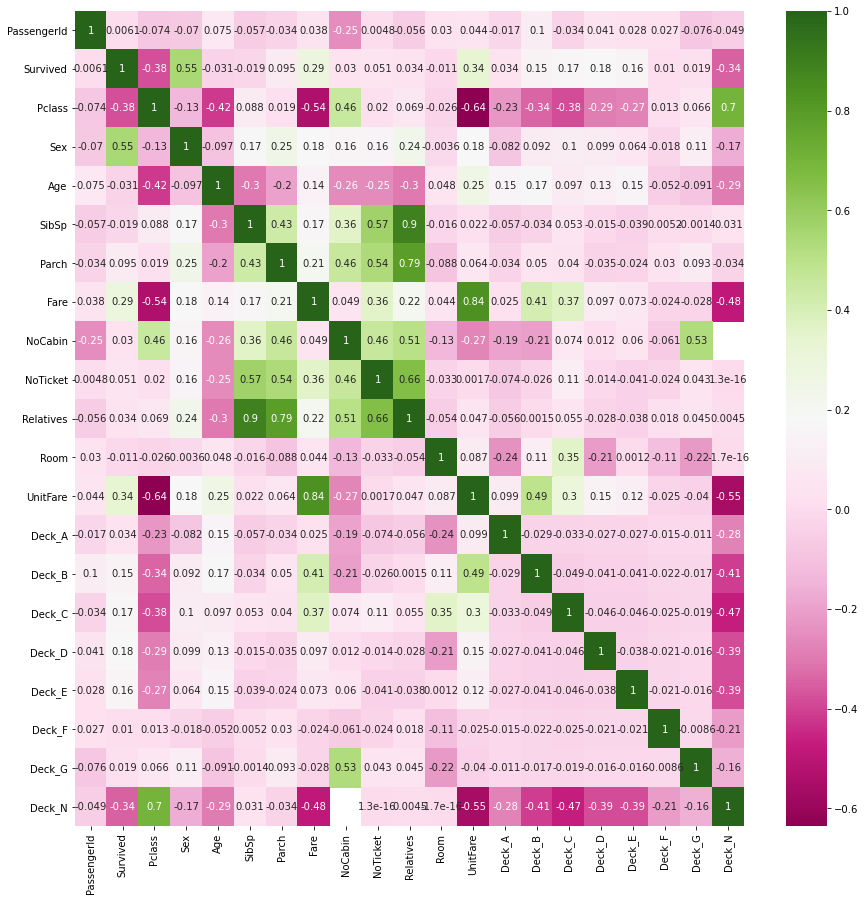

In [262]:
corrMatrix = df_train.corr()
plt.figure(figsize=(15,15))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

In [263]:
Counter(df_train["Title"])
from collections import defaultdict

title_map = dict()
title_map[" Mr"] = "Mr"
title_map[" Mrs"] = "Mrs"
title_map[" Miss"] = "Miss"
title_map[" Master"] = "Master"
title_map[" Dr"] = "Dr"

for key in Counter(df_train["Title"]).keys():
    if not key in title_map.keys():
        title_map[key] = "E"
        
print(title_map)

df_train = df_train.replace({"Title": title_map})

one_hot = pd.get_dummies(df_train["Title"], prefix="Title")
df_train = df_train.join(one_hot)
df_train

{' Mr': 'Mr', ' Mrs': 'Mrs', ' Miss': 'Miss', ' Master': 'Master', ' Dr': 'Dr', ' Don': 'E', ' Rev': 'E', ' Ms': 'E', ' Major': 'E', ' Lady': 'E', ' Mlle': 'E', ' Col': 'E', ' Capt': 'E', ' the Countess': 'E', ' Jonkheer': 'E'}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_E,Deck_F,Deck_G,Deck_N,Title_Dr,Title_E,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,0,0,0,1,0,0,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,1,0,0,0,1,0,0
3,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,0,0,0,1,0,0,0,0,1,0
4,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,884,0,2,"Banfield, Mr. Frederick James",0,28.0,0,0,C.A./SOTON 34068,10.5000,...,0,0,0,1,0,0,0,0,1,0
620,885,0,3,"Sutehall, Mr. Henry Jr",0,25.0,0,0,SOTON/OQ 392076,7.0500,...,0,0,0,1,0,0,0,0,1,0
621,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,...,0,0,0,0,0,0,0,1,0,0
622,889,0,3,"Johnston, Miss. Catherine Helen \Carrie\""""",1,NaN,1,2,W./C. 6607,23.4500,...,0,0,0,1,0,0,0,1,0,0


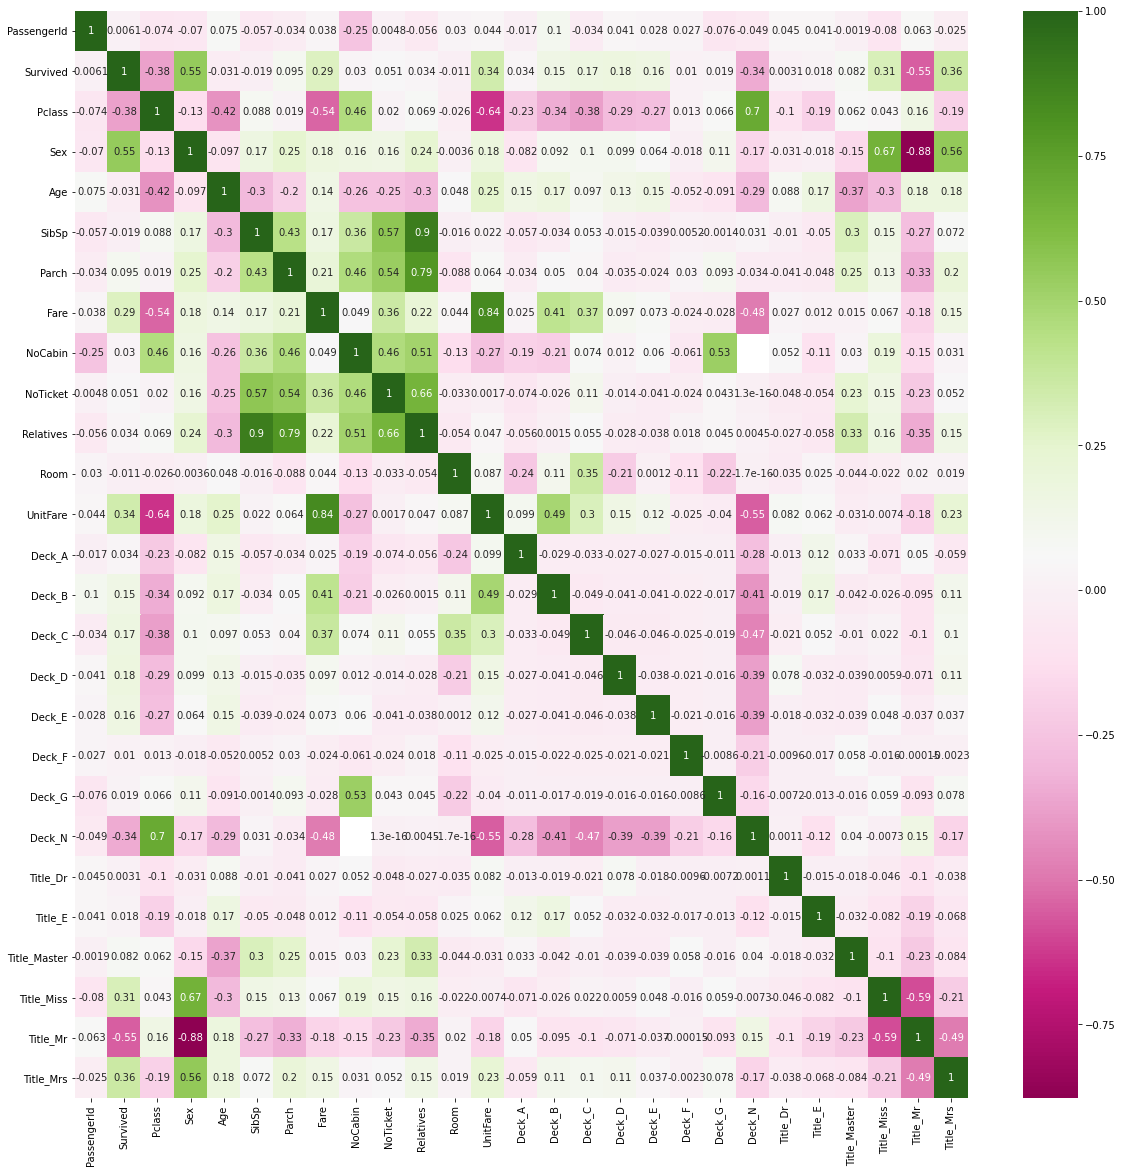

In [265]:
corrMatrix = df_train.corr()
plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

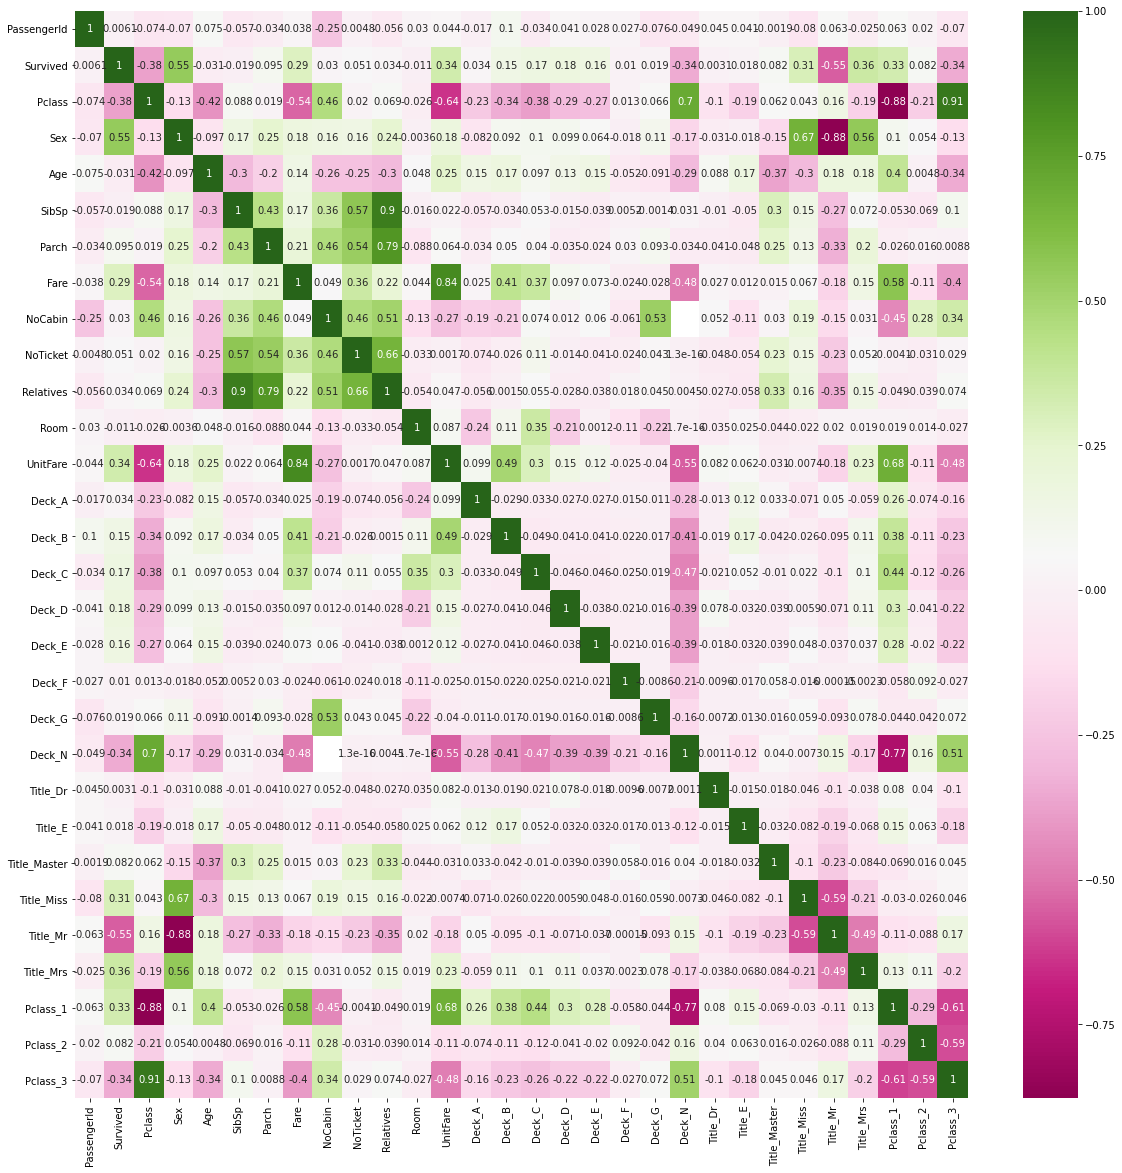

In [266]:
one_hot = pd.get_dummies(df_train["Pclass"], prefix="Pclass")
df_train = df_train.join(one_hot)
df_train

corrMatrix = df_train.corr()
plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

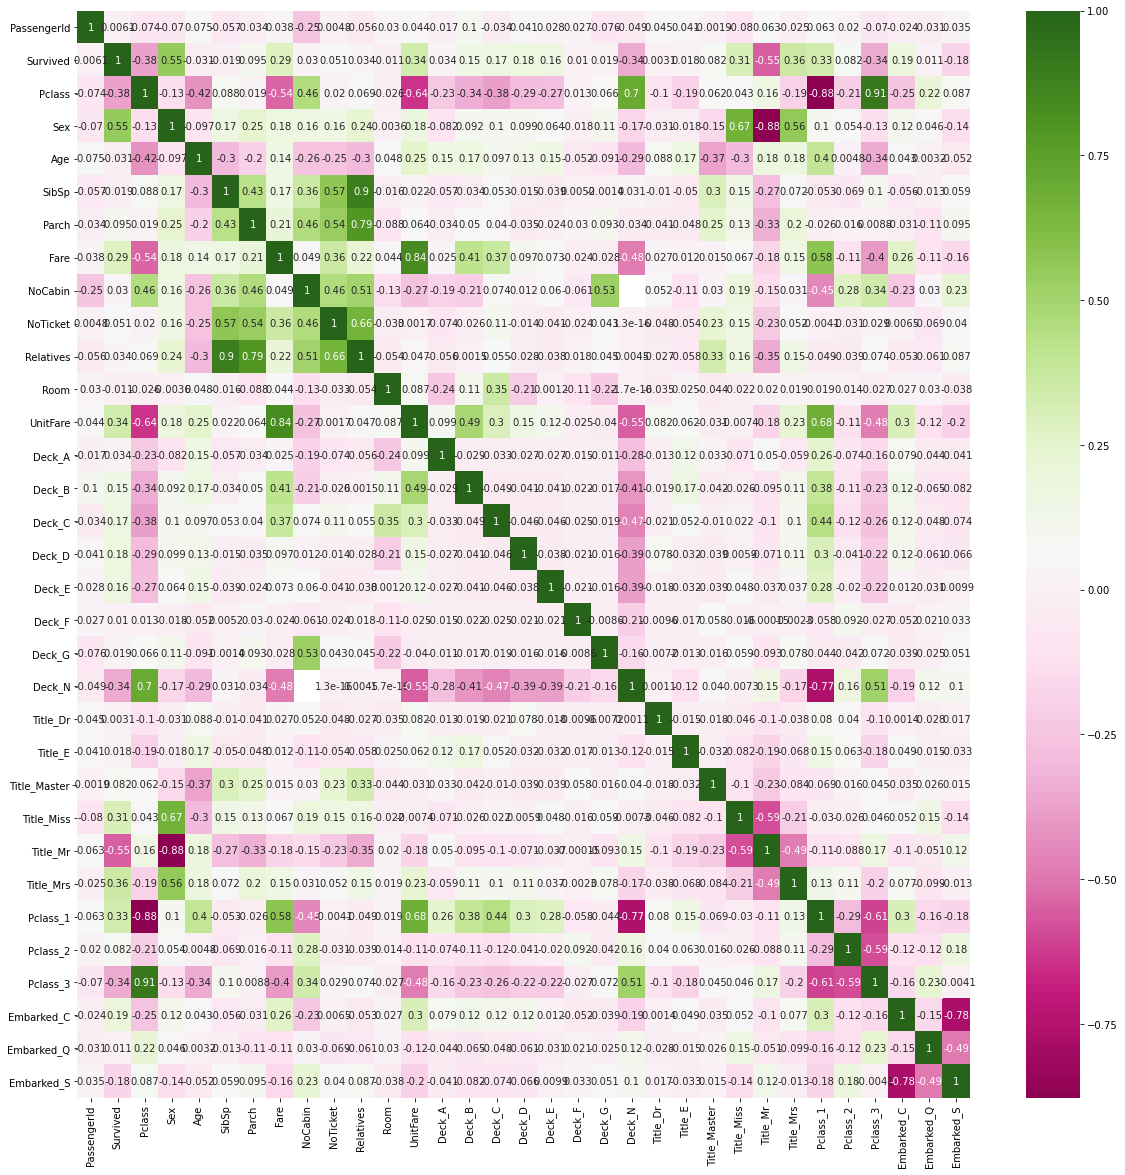

In [267]:
one_hot = pd.get_dummies(df_train["Embarked"], prefix="Embarked")
df_train = df_train.join(one_hot)
df_train

corrMatrix = df_train.corr()
plt.figure(figsize=(20,20))
sn.heatmap(corrMatrix, annot=True, cmap="PiYG")
plt.show()

A túléléssel a legnagyobb korrelációt az osztály